In [10]:
from IPython.display import display
from IPython.display import clear_output
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from enum import Enum
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

In [11]:
class Distribution(Enum):
    EXP = 0
    UNIFORM = 1
    NORMAL = 2
    POISSON = 3

In [12]:
class Points:
    def __init__(self, nOfMarkers = 0, statistics = None):
        self.statistics = statistics
        self.nOfMarkers = nOfMarkers
        
    def addMarkers(self, markers):
        self.nOfMarkers += markers
    
    def deleteMarkers(self, markers):
        self.nOfMarkers -= markers

    def __repr__(self):
        return self.statistics

In [13]:
class Transition:
    def __init__(self, delay = 0, parametersDistributionDelay = None, distributionDelay = None, statistics = None, probability = None, priority = 1, timeToSave = False, timeToCompute = False):
        self.delay = delay
        self.parametersDistributionDelay = parametersDistributionDelay
        self.distributionDelay = distributionDelay
        self.statistics = statistics
        self.probability = probability
        self.priority = priority
        self.timeToSave = timeToSave
        self.timeToCompute = timeToCompute
        self.arcsOut = []
        self.arcsIn = []
        self.markerTimes = {}
    
    def arcFree(self):
        return all(arc.arcFree() for arc in self.arcsIn)
    
    def checkMarkersDelay(self, currentTime):
        global nRound
        if round(currentTime, nRound) in self.markerTimes.keys():
            del self.markerTimes[round(currentTime, nRound)]
            global timeQueue, timeProcess
            if self.timeToCompute:
                timeProcess.append(currentTime - timeQueue.pop(0))
            for arc in self.arcsOut:
                arc.moveTo()
        
    def generateRandomDelay(self):
        if self.distributionDelay is Distribution.EXP:
            result = np.random.exponential(**self.parametersDistributionDelay)
        elif self.distributionDelay is Distribution.UNIFORM:
            result = np.random.uniform(**self.parametersDistributionDelay)
        elif self.distributionDelay is Distribution.NORMAL:
            result = np.random.normal(**self.parametersDistributionDelay)
        elif self.distributionDelay is Distribution.POISSON:
            result = np.random.poisson(**self.parametersDistributionDelay)
        global nRound
        return round(result, nRound)

    def makeTransition(self, currentTime):
        delay = self.delay if self.distributionDelay is None else self.generateRandomDelay()
        global timeQueue, timeProcess
        if self.timeToSave:
            timeQueue.append(currentTime)
        for arc in self.arcsIn:
            arc.moveFrom(currentTime, delay)

    def __repr__(self):
        return self.statistics

In [14]:
class Arc:
    def __init__(self, first, last, multiplicity = 1, isStatistics = False):
        self.first = first
        self.last = last
        self.multiplicity = multiplicity
        self.isStatistics = isStatistics

        if isinstance(last, Transition):
            last.arcsIn.append(self)  
        elif isinstance(first, Transition):
            first.arcsOut.append(self)

    def arcFree(self):
        return self.first.nOfMarkers >= self.multiplicity
    
    def moveFrom(self, currentTime, delay):
        if not self.isStatistics:
            self.first.deleteMarkers(self.multiplicity)
        global nRound
        timeStamp = round(currentTime + delay, nRound)
        if timeStamp in self.last.markerTimes:
            self.last.markerTimes[timeStamp] += self.multiplicity
        else:
            self.last.markerTimes[timeStamp] = self.multiplicity
            
    def moveTo(self):
        self.last.addMarkers(self.multiplicity)

    def __repr__(self):
        return f"{self.first} -> {self.last}"

In [19]:
class Model:
    def __init__(self, transitions, points, arcs, modelingPeriod, printInfo = False):
        self.transitions = transitions
        self.points = points
        self.arcs = arcs
        self.modelingPeriod = modelingPeriod
        self.printInfo = printInfo
        global nRound
        self.deltaTime = round(1 / 10 ** nRound, nRound)
        self.time = round(0.000, nRound) if nRound > 1 else 0
        self.markerStatistics = {point: [] for point in points}
    
    def run(self, returnTarget = False, returnMarkers = None):
        if self.printInfo:
            self.displayIntermediateResults()
        while self.time < self.modelingPeriod:
            transitionFree = any(transition.arcFree() or len(transition.markerTimes) > 0 for transition in self.transitions)
            if not transitionFree:
                break
            resolveds = self.transitionsWithResolvedConflicts()
            for transition in resolveds:
                if transition.arcFree():
                    transition.makeTransition(self.time)
            for transition in self.transitions:
                transition.checkMarkersDelay(self.time)
            self.makeStatistics()
            self.time += self.deltaTime
            if self.printInfo:
                self.displayIntermediateResults()
        self.result, self.resultTarget = self.displayResults(returnTarget)
        if returnMarkers:
            return self.markerStatistics[[point for point in self.points if point.statistics == returnMarkers][0]]
        else:
            return self.resultTarget if returnTarget else self.result
    
    def transitionsWithResolvedConflicts(self):
        conflicts = []
        resolveds = []     
        for point in self.points:
            pointArcsOut = [*filter(lambda arc: arc.first is point, self.arcs)]
            resolved = [*filter(lambda trans: trans.arcFree(), map(lambda arc: arc.last, pointArcsOut))]
            if len(resolved) > 1:
                conflicts.append(resolved)
        flatteningList = set(np.array(conflicts).flatten().tolist()) 
        for point in self.points:
            pointArcsOut = [*filter(lambda arc: arc.first is point, self.arcs)]
            resolved = [*filter(lambda trans: trans.arcFree(), map(lambda arc: arc.last, pointArcsOut))]
            if not flatteningList.intersection(resolved):
                resolveds += resolved
        del flatteningList
        for conflict in conflicts:
            if conflict[0].probability is not None:
                p = [c.probability for c in conflict]
                resolved = np.random.choice(conflict, p=p)
            elif len(np.unique([c.priority for c in conflict if c.priority is not None])) > 1:
                priority = [c.priority for c in conflict]
                resolved = conflict[np.argmax(priority)]
            else:
                resolved = np.random.choice(conflict)
            resolveds += [resolved]
        return list(set(resolveds))
    
    
    def makeResults(self):
        results = {point: {} for point in self.points}
        for point, stats in self.markerStatistics.items():
            results[point]["minimum"] = min(stats)
            results[point]["maximum"] = max(stats)
            results[point]["avarege"] = round(sum(stats) / len(stats), 5)
            results[point]["result"] = stats[-1]
            if point.statistics == 'Передано основним каналом':
                mainMsgs = stats[-1]
            elif point.statistics == 'Передано резервним каналом':
                reservMsgs = stats[-1]
            elif point.statistics == 'Кількість переданих повідомлень':
                nMsgs = stats[-1]
            elif point.statistics == 'Кількість збоїв':
                allFails = stats[-1]
            elif point.statistics == 'Кількість переривань':
                nInteruptions = stats[-1]
                
        return results, {'Частота відмов': round(allFails / self.time, 5),
                              'Доля відмов': round(allFails / nMsgs, 5),
                              'Кількість переривань': nInteruptions,
                              'Завантаженість резервного каналу': round(reservMsgs / nMsgs, 5),
                              'Передано основним каналом': mainMsgs,
                              'Передано резервним каналом': reservMsgs}

    def displayResults(self, returnTarget):
        formattedRecords = []
        resulting, resultTarget = self.makeResults()
        for point, stats in resulting.items():
            record = stats
            record["information"] = point.statistics
            formattedRecords.append(record)
        if not returnTarget:
            print(f"Час моделювання - {self.time}")
            display(pd.DataFrame(
                formattedRecords,
                columns=[
                    "information",
                    "minimum",
                    "maximum",
                    "avarege",
                    "result"
                ]
            ))
        return resulting, resultTarget

    def displayIntermediateResults(self): 
        print(f"Витрачено часу: {self.time}\n=====  Points  =====")
        for point in self.points:
            print(point, point.nOfMarkers)
        print("=====  Transitions  =====")
        for transition in self.transitions:
            print(transition, transition.markerTimes)
        print()
    
    def makeStatistics(self):
        for point in self.points:
            self.markerStatistics[point].append(point.nOfMarkers)

In [20]:
def modeling(modelingPeriod, printInfo = False, **kwargs):
    generator = Points(nOfMarkers = 1, statistics = "Надходження повідомлення")
    queue = Points(nOfMarkers = 0, statistics = "Накопичувач")
    mainChannelFree = Points(nOfMarkers = 1, statistics = "Основний канал вільний")
    reservChannelFree = Points(nOfMarkers = 1, statistics = "Резервний канал вільний")
    buffer = Points(nOfMarkers = 0, statistics = "Буфер")
    nInteruptions = Points(nOfMarkers = 0, statistics = "Кількість переривань")
    mainMsgs = Points(nOfMarkers = 0, statistics = "Передано основним каналом")
    allMsgs = Points(nOfMarkers = 0, statistics = "Кількість переданих повідомлень")
    reservMsgs = Points(nOfMarkers = 0, statistics = "Передано резервним каналом")
    mainAccessMarker = Points(nOfMarkers = 1, statistics = "Маркер доступу до основного каналу")
    allFails = Points(nOfMarkers = 0, statistics = "Кількість збоїв")
    P2 = Points(nOfMarkers = 1, statistics = "P2")
    fixedFails = Points(nOfMarkers = 0, statistics = "Збій усунено")
    P1 = Points(nOfMarkers = 1, statistics = "P1")
    failureOccurred = Points(nOfMarkers = 0, statistics = "Відбувся збій")
    runningReserv = Points(nOfMarkers = 0, statistics = "Потреба запуску резервного каналу")
    runReserv = Points(nOfMarkers = 0, statistics = "Резервний канал запущено")
    
    receivingMessageTrans = Transition(
        distributionDelay = Distribution.UNIFORM,
        parametersDistributionDelay = {"low": kwargs['R'] - kwargs['rRound'], "high": kwargs['R'] + kwargs['rRound']},
        statistics = "Перехід до накопичувача",
        timeToSave = True)
    mainTrans = Transition(
        distributionDelay = Distribution.UNIFORM,
        parametersDistributionDelay = {"low": kwargs['T1'] - kwargs['t1Round'], "high": kwargs['T1'] + kwargs['t1Round']},
        statistics="Основний канал")
    messageSendedTrans = Transition(
        delay = 0,
        statistics = "Завершення надсилання",
        timeToCompute = True)
    interuptionTrans = Transition(
        delay = 0,
        priority = 2,
        statistics = "Переривання")
    reservTrans = Transition(
        distributionDelay = Distribution.UNIFORM,
        parametersDistributionDelay = {"low": kwargs['T1'] - kwargs['t1Round'], "high": kwargs['T1'] + kwargs['t1Round']},
        priority = 2,
        statistics = "Резервний канал",
        timeToCompute = True)
    failFixingTrans = Transition(
        distributionDelay = Distribution.UNIFORM,
        parametersDistributionDelay = {"low": kwargs['T4'] - kwargs['t4Round'], "high": kwargs['T4'] + kwargs['t4Round']},
        statistics = "Усунення збою")
    markerReturningTrans = Transition(
        delay = 0,
        statistics = "Повернення маркеру")
    failWriteTrans = Transition(
        delay = 0,
        statistics = "Запис збою")
    failGenerateTrans = Transition(
        distributionDelay = Distribution.UNIFORM,
        parametersDistributionDelay = {"low": kwargs['T2'] - kwargs['t2Round'], "high": kwargs['T2'] + kwargs['t2Round']},
        statistics = "Генерація збою")
    runReservTrans = Transition(
        delay = T3,
        statistics = "Запуск резервного каналу")

    arc0 = Arc(first = generator, last = receivingMessageTrans)
    arc1 = Arc(first = receivingMessageTrans, last = generator)
    arc2 = Arc(first = receivingMessageTrans, last = queue)
    arc3 = Arc(first = queue, last = mainTrans)
    arc4 = Arc(first = interuptionTrans, last = queue)
    arc5 = Arc(first = queue, last = reservTrans)
    arc6 = Arc(first = mainAccessMarker, last = mainTrans, isStatistics = True)
    arc7 = Arc(first = mainTrans, last = buffer)
    arc8 = Arc(first = mainTrans, last = mainChannelFree)
    arc9 = Arc(first = mainChannelFree, last = mainTrans)
    arc10 = Arc(first = buffer, last = messageSendedTrans)
    arc11 = Arc(first = buffer, last = interuptionTrans)
    arc12 = Arc(first = messageSendedTrans, last = mainMsgs)
    arc13 = Arc(first = messageSendedTrans, last = allMsgs)
    arc14 = Arc(first = interuptionTrans, last = nInteruptions)
    arc24 = Arc(first = failureOccurred, last = interuptionTrans, isStatistics = True)
    arc15 = Arc(first = reservTrans, last = allMsgs)
    arc16 = Arc(first = reservTrans, last = reservMsgs)
    arc17 = Arc(first = reservTrans, last = reservChannelFree)
    arc18 = Arc(first = reservChannelFree, last = reservTrans)
    arc19 = Arc(first = runReserv, last = reservTrans, isStatistics = True)
    arc24 = Arc(first = runReserv, last = markerReturningTrans)
    arc20 = Arc(first = runReservTrans, last = runReserv)
    arc21 = Arc(first = runningReserv, last = runReservTrans)
    arc22 = Arc(first = failGenerateTrans, last = runningReserv)
    arc23 = Arc(first = failGenerateTrans, last = failureOccurred)
    arc29 = Arc(first = failureOccurred, last = failFixingTrans, isStatistics = True)
    arc30 = Arc(first = failureOccurred, last = failWriteTrans, isStatistics = True)
    arc25 = Arc(first = failureOccurred, last = markerReturningTrans)
    arc26 = Arc(first = P2, last = failFixingTrans)
    arc27 = Arc(first = markerReturningTrans, last = P2)
    arc28 = Arc(first = failFixingTrans, last = fixedFails)
    arc29 = Arc(first = fixedFails, last = markerReturningTrans)
    arc30 = Arc(first = markerReturningTrans, last = mainAccessMarker)
    arc31 = Arc(first = markerReturningTrans, last = P1)
    arc32 = Arc(first = P1, last = failGenerateTrans)
    arc33 = Arc(first = mainAccessMarker, last = failWriteTrans)
    arc34 = Arc(first = failWriteTrans, last = allFails)

    arcs = [arc0, arc1, arc2, arc3, arc4, arc5, arc6, arc7, arc8, arc9, arc10,
            arc11, arc12, arc13, arc14, arc24, arc15, arc16,
            arc17, arc18, arc19, arc24, arc20, arc21, arc22, arc23, arc25, arc26,
            arc27, arc28, arc29, arc30, arc31, arc32, arc33, arc34]
    

    model = Model(transitions = [receivingMessageTrans,
                                 mainTrans,
                                 messageSendedTrans,
                                 interuptionTrans,
                                 reservTrans,
                                 failWriteTrans,
                                 failFixingTrans,
                                 markerReturningTrans,
                                 failGenerateTrans,
                                 runReservTrans],
                  points = [generator,
                               queue,
                               mainChannelFree,
                               reservChannelFree,
                               buffer,
                               nInteruptions,
                               mainMsgs,
                               allMsgs,
                               reservMsgs,
                               mainAccessMarker,
                               allFails,
                               P2,
                               fixedFails,
                               P1,
                               failureOccurred,
                               runningReserv,
                               runReserv],
                  arcs = arcs,
                  modelingPeriod = modelingPeriod,
                  printInfo = False)
    
    return model

In [21]:
timeQueue = []
timeProcess = []

modelingPeriod = 10000.0
nRound = 0

R = 9             
T1 = 7             
T2 = 200
T3 = 2
T4 = 23            

rRound = 4     
t1Round = 3   
t2Round = 35 
t4Round = 7   

simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)

result = simulation.run(returnTarget = False)

dataRow = []
for res in result:
    dataRow.append(result[res])   
data = pd.DataFrame(dataRow)
data.to_excel('Testing.xlsx', index = [0])

Час моделювання - 10000.0


,information,minimum,maximum,avarege,result
0,Надходження повідомлення,0,1,0.1007,1
1,Накопичувач,0,3,0.2849,1
2,Основний канал вільний,0,1,0.3649,0
3,Резервний канал вільний,0,1,0.9114,1
4,Буфер,0,1,0.0916,0
5,Кількість переривань,0,42,21.6863,42
6,Передано основним каналом,0,874,436.0627,874
7,Кількість переданих повідомлень,0,1005,501.5320,1005
8,Передано резервним каналом,0,131,65.4693,131
9,Маркер доступу до основного каналу,0,1,0.8937,1


In [22]:
timeQueue = []
timeProcess = []
dataRow = []

modelingPeriod = 10000.0
nRound = 0

rArray  = [9]
t1Array = [7]
t2Array = list(range(200,300))
t3Array = [2]
t4Array = [23]

rRoundArray = [0]
t1RoundArray = [0]
t2RoundArray = [0]
t4RoundArray = [0]

for row in product(t1Array, t1RoundArray, t2Array, t2RoundArray, t3Array, t4Array, t4RoundArray, rArray, rRoundArray):
    T1, t1Round, T2, t2Round, T3, T4, t4Round, R, rRound = row

    simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)
    
    result = simulation.run(returnTarget = True)
    
    dataRow.append(dict({'T1': T1, 't1Round': t1Round, 
                         'T2': T2, 't2Round': t2Round, 
                         'T3': T3,
                         'T4': T4, 't4Round': t4Round}, **result))
data = pd.DataFrame(dataRow)
data.sort_values('Частота відмов', ascending = False).head(10)

,T1,t1Round,T2,t2Round,T3,T4,t4Round,Частота відмов,Доля відмов,Кількість переривань,Завантаженість резервного каналу,Передано основним каналом,Передано резервним каналом
0,7,0,200,0,2,23,0,0.0044,0.04404,36,0.13113,868,131
1,7,0,201,0,2,23,0,0.0044,0.04404,34,0.12913,870,129
2,7,0,202,0,2,23,0,0.0043,0.04304,37,0.12613,873,126
4,7,0,204,0,2,23,0,0.0043,0.04304,43,0.12913,870,129
5,7,0,205,0,2,23,0,0.0043,0.04304,34,0.12813,871,128
6,7,0,206,0,2,23,0,0.0043,0.04304,40,0.12312,876,123
3,7,0,203,0,2,23,0,0.0043,0.04304,43,0.12913,870,129
10,7,0,210,0,2,23,0,0.0042,0.04204,39,0.12112,878,121
12,7,0,212,0,2,23,0,0.0042,0.04208,39,0.12024,878,120
11,7,0,211,0,2,23,0,0.0042,0.04204,33,0.12312,876,123


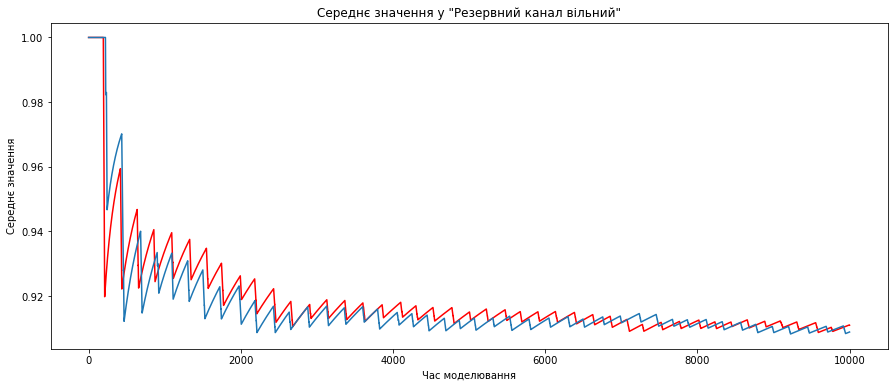

In [23]:
timeQueue = []
timeProcess = []

modelingPeriod = 10000.0
nRound = 0

R = 9             
T1 = 7             
T2 = 200
T3 = 2
T4 = 23            

rRound = 4     
t1Round = 3   
t2Round = 35 
t4Round = 7

simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)

result1 = simulation.run(returnMarkers = 'Резервний канал вільний')

simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)

result2 = simulation.run(returnMarkers = 'Резервний канал вільний')

clear_output()


avarageResult1 = []
avarageResult2 = []
for i in range(len(result1)):
    avarageResult1.append(sum(result1[:i + 1]) / len(result1[:i + 1]))
    avarageResult2.append(sum(result2[:i + 1]) / len(result2[:i + 1]))

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(avarageResult1, color = 'red')
ax.plot(avarageResult2)
ax.set_xlabel(u'Час моделювання')
ax.set_ylabel(u'Середнє значення')
ax.set_title(u'Середнє значення у "Резервний канал вільний"');

In [24]:
timeQueue = []
timeProcess = []

modelingPeriod = 60000.0
nRound = 0

R = 9             
T1 = 7             
T2 = 200
T3 = 2
T4 = 23            

rRound = 4     
t1Round = 3   
t2Round = 35 
t4Round = 7

simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)

result = simulation.run(returnTarget = False)

Час моделювання - 60000.0


,information,minimum,maximum,avarege,result
0,Надходження повідомлення,0,1,0.10030,0
1,Накопичувач,0,3,0.26930,0
2,Основний канал вільний,0,1,0.36107,0
3,Резервний канал вільний,0,1,0.90775,0
4,Буфер,0,1,0.09120,0
5,Кількість переривань,0,240,119.65297,240
6,Передано основним каналом,0,5232,2610.23990,5232
7,Кількість переданих повідомлень,0,6016,2999.90738,6016
8,Передано резервним каналом,0,784,389.66748,784
9,Маркер доступу до основного каналу,0,1,0.89157,1


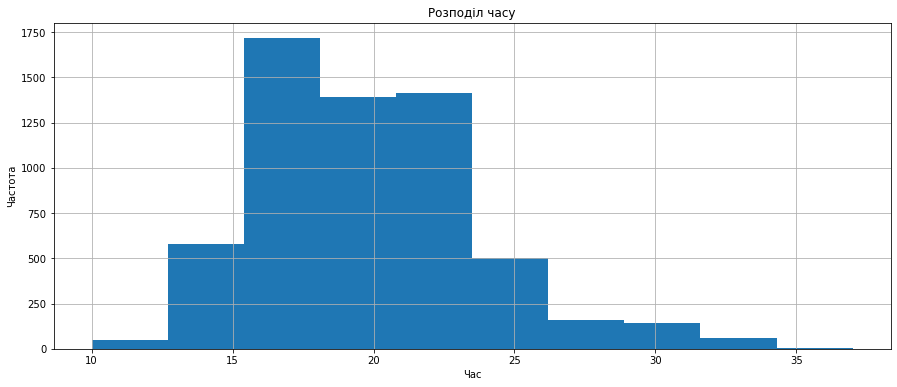

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.hist(timeProcess)
ax.grid(True)
ax.set_xlabel(u'Час')
ax.set_ylabel(u'Частота')
ax.set_title(u'Розподіл часу')
plt.show()

In [26]:
def makingUniform(x, a, b, nBins = 30, nMinimum = 20):
    obsFreq = {}
    expFreq = {}
    start = x.min()
    end = x.max() + 1e-9
    n = x.size
    h = (end - start) / nBins
    curr = start
    i = 0
    while curr <= end:
        obsFreq[i] = np.sum((x >= curr) & (x < (curr+h)))
        p_i = np.abs(st.uniform(a, b).cdf(curr) - st.uniform(a, b).cdf(curr + h))
        expFreq[i] = p_i * n
        i += 1
        curr += h
    return normilizeUniform(obsFreq, expFreq, nMinimum = nMinimum)

def normilizeUniform(obsFreq, expFreq, nMinimum = 100):
    assert len(obsFreq) > 2 or len(expFreq) > 2
    for i in sorted(obsFreq.keys(), reverse = True)[:-1]:
        if obsFreq[i] <= nMinimum or expFreq[i] <= nMinimum:
            obsFreq[i-1] += obsFreq[i]
            expFreq[i-1] += expFreq[i]
            del obsFreq[i], expFreq[i]
    for i in sorted(obsFreq.keys())[:-1]:
        if obsFreq[i] <= nMinimum or expFreq[i] <= nMinimum:
            j = 1
            while not i + j in obsFreq:
                j += 1
            obsFreq[i+j] += obsFreq[i]
            expFreq[i+j] += expFreq[i]
            del obsFreq[i], expFreq[i]
    return obsFreq, expFreq

timeProcess = np.array(timeProcess)
print(f'Maximum Time Process: {timeProcess.max()}')
x = np.linspace(0, timeProcess.max(), 1000000)
b = (x.mean() + np.sqrt(3) * x.std(ddof = 1))
a = 2 * x.mean() - b
obsFreq, expFreq = makingUniform(timeProcess, a, b, nBins = 10, nMinimum = 200)
print(f'a: {a}\nb: {b}')

alpha = 0.05
stat_val, p_value = st.chisquare(list(obsFreq.values()), list(expFreq.values()), ddof = 2)
print(f'stat_val: {round(stat_val, 3)}\np_value: {round(p_value, 3)}')
if p_value < alpha:
    print(f'Не можна прийняти нульову гіпотезу на рівні значимості alpha = {alpha}')
else:
    print('Можна прийняти нульову гіпотезу про розподіл данних з заданим параметром')

Maximum Time Process: 37.0
a: -2.77500254384222e-05
b: 37.000027750025424
stat_val: 9011.358
p_value: 0.0
Не можна прийняти нульову гіпотезу на рівні значимості alpha = 0.05


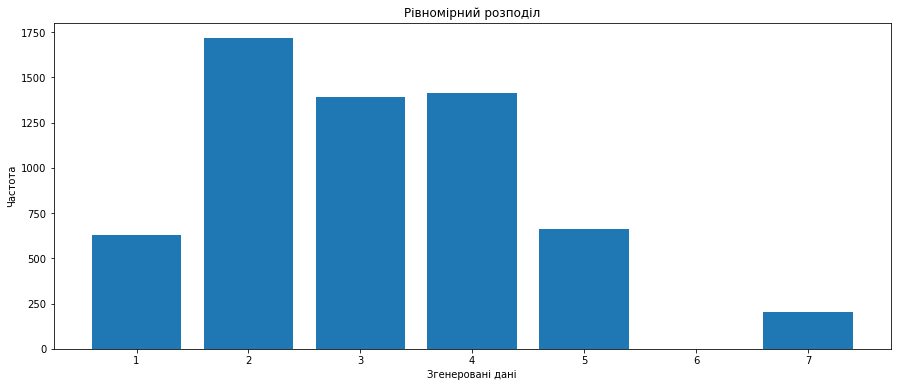

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.bar(x = list(obsFreq.keys()), height = list(obsFreq.values()))
ax.set_xlabel(u'Згенеровані дані')
ax.set_ylabel(u'Частота')
ax.set_title(u'Рівномірний розподіл');

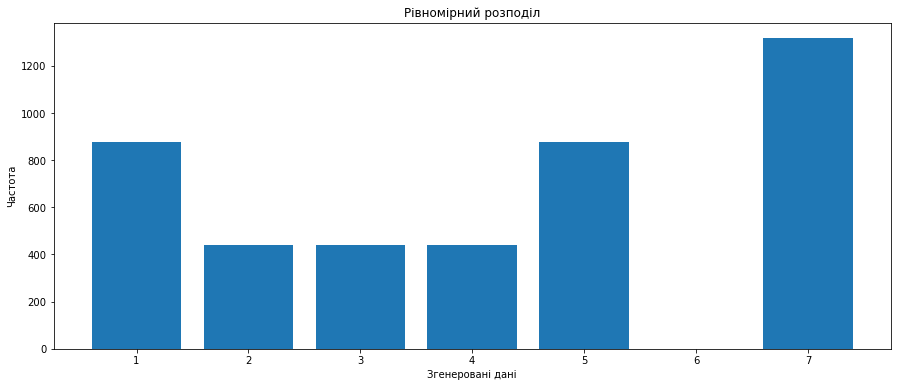

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.bar(x = list(expFreq.keys()), height = list(expFreq.values()))
ax.set_xlabel(u'Згенеровані дані')
ax.set_ylabel(u'Частота')
ax.set_title(u'Рівномірний розподіл');

In [29]:
def makingGoodDist(times):
    results = []
    names = ['expon', 'norm', 'uniform', 'dweibull']
    params = {}
    for name in names:
        dist = getattr(st, name)
        param = dist.fit(times)
        params[name] = param
        D, p = st.kstest(times, name, args = param)
        print(f'{name} distribution p_value: {str(p)}')
        results.append((name, p))
    goodDist, goodP = (max(results, key=lambda item: item[1]))
    print(f'\nІдеальний розподіл: {str(goodDist)}')
    print(f'Ідеальне p_value: {str(goodP)}')
    print(f'Параметри: {str(params[goodDist])}')
    return goodDist, goodP, params[goodDist]

goodDist, p_value, params = makingGoodDist(timeProcess)

alpha = 0.05
print(f'stat_val: {round(stat_val, 3)}\np_value: {round(p_value, 3)}')
if p_value < alpha:
    print(f'\nНе можна прийняти нульову гіпотезу на рівні значемості alpha = {alpha}')
else:
    print('Можна прийняти нульову гіпотезу про розподіл данних з заданим параметром')
    print(f'Найкращий розподіл: {goodDist}')
    print(f'Params: {params}')
    print(f'p_value: {round(p_value, 3)}')

expon distribution p_value: 0.0
norm distribution p_value: 7.503895696841507e-59
uniform distribution p_value: 0.0
dweibull distribution p_value: 1.782739196928668e-30

Ідеальний розподіл: dweibull
Ідеальне p_value: 1.782739196928668e-30
Параметри: (1.235884419171245, 19.534806373531115, 3.1380009965384033)
stat_val: 9011.358
p_value: 0.0

Не можна прийняти нульову гіпотезу на рівні значемості alpha = 0.05


In [30]:
dataRow = []
timeQueue = []
timeProcess = []

modelingPeriod = 40000.0
nRound = 0

rArray  = [9]
t1Array = [7]
t2Array = list(range(200, 1001, 50))
t3Array = [2]
t4Array = [23]

rRoundArray = [0]
t1RoundArray = [0]
t2RoundArray = [0]
t4RoundArray = [0]

for row in product(t1Array, t1RoundArray, t2Array, t2RoundArray, t3Array, t4Array, t4RoundArray, rArray, rRoundArray):
    T1, t1Round, T2, t2Round, T3, T4, t4Round, R, rRound = row

    simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)
    
    result = simulation.run(returnTarget = True)
    
    dataRow.append(dict({'T1': T1, 't1Round': t1Round, 
                         'T2': T2, 't2Round': t2Round, 
                         'T3': T3, 'T4': T4, 't4Round': t4Round,
                         'modelingPeriod': modelingPeriod}, **result))

    
data = pd.DataFrame(dataRow)
data.head(10)

,T1,t1Round,T2,t2Round,T3,T4,t4Round,modelingPeriod,Частота відмов,Доля відмов,Кількість переривань,Завантаженість резервного каналу,Передано основним каналом,Передано резервним каналом
0,7,0,200,0,2,23,0,40000.0,0.00443,0.04427,158,0.12856,3484,514
1,7,0,250,0,2,23,0,40000.0,0.00363,0.03627,126,0.10555,3576,422
2,7,0,300,0,2,23,0,40000.0,0.00305,0.03051,109,0.08877,3644,355
3,7,0,350,0,2,23,0,40000.0,0.00265,0.02651,96,0.07677,3692,307
4,7,0,400,0,2,23,0,40000.0,0.00232,0.02326,84,0.06752,3729,270
5,7,0,450,0,2,23,0,40000.0,0.00210,0.02101,74,0.06128,3753,245
6,7,0,500,0,2,23,0,40000.0,0.00190,0.01900,70,0.05476,3780,219
7,7,0,550,0,2,23,0,40000.0,0.00172,0.01725,61,0.05026,3798,201
8,7,0,600,0,2,23,0,40000.0,0.00158,0.01575,55,0.04626,3814,185
9,7,0,650,0,2,23,0,40000.0,0.00147,0.01475,52,0.04301,3827,172


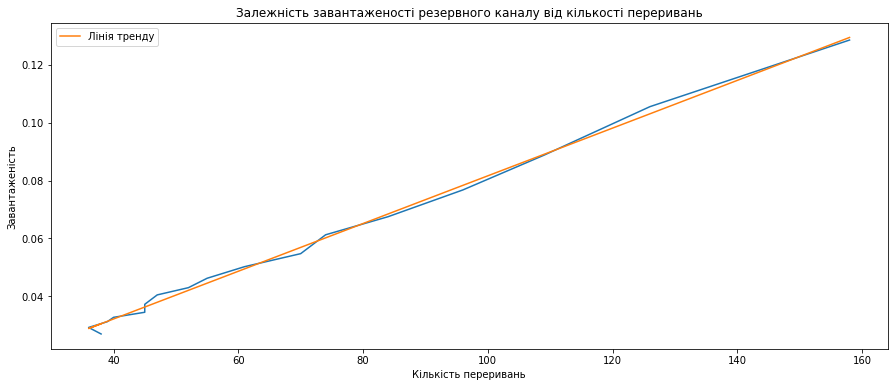

In [31]:
temp = data.sort_values('Завантаженість резервного каналу', ascending = True)[['Кількість переривань', 'Завантаженість резервного каналу']].values
z = np.polyfit(temp[:, 0], temp[:, 1], 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1])
ax.plot(temp[:, 0], p(temp[:, 0]), label = 'Лінія тренду')
ax.set_xlabel(u'Кількість переривань')
ax.set_ylabel(u'Завантаженість')
plt.legend()
ax.set_title(u'Залежність завантаженості резервного каналу від кількості переривань');

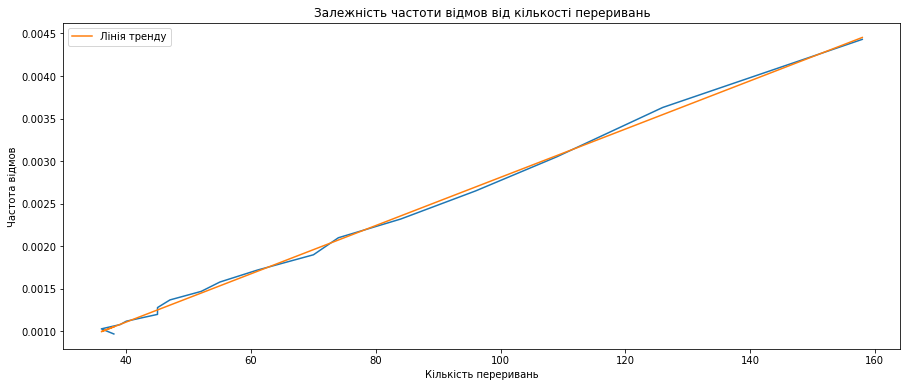

In [32]:
temp = data.sort_values('Частота відмов', ascending = True)[['Кількість переривань', 'Частота відмов']].values
z = np.polyfit(temp[:, 0], temp[:, 1], 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(temp[:, 0], temp[:, 1])
ax.plot(temp[:, 0], p(temp[:, 0]), label = 'Лінія тренду')
ax.set_xlabel(u'Кількість переривань')
ax.set_ylabel(u'Частота відмов')
plt.legend()
ax.set_title(u'Залежність частоти відмов від кількості переривань');




In [40]:
dataRow = []
timeQueue = []
timeProcess = []

modelingPeriod = 10000.0
nRound = 0

rArray  = [9, 13, 17]
t1Array = [7, 11, 15]
t2Array = [200, 300, 400]
t3Array = [3, 4, 5]
t4Array = [23, 30, 37]

rRoundArray = [4]
t1RoundArray = [3]
t2RoundArray = [35]
t4RoundArray = [7]

for row in product(t1Array, t1RoundArray, t2Array, t2RoundArray, t3Array, t4Array, t4RoundArray, rArray, rRoundArray):
    T1, t1Round, T2, t2Round, T3, T4, t4Round, R, rRound = row

    simulation = modeling(modelingPeriod, printInfo = False,T1 = T1, t1Round = t1Round,
                      T2 = T2, t2Round = t2Round, T3 = T3, T4 = T4,
                      t4Round = t4Round, R = R, rRound = rRound)
    
    result = simulation.run(returnTarget = True)
    
    dataRow.append(dict({'T1': T1, 't1Round': t1Round, 
                         'T2': T2, 't2Round': t2Round, 
                         'T3': T3, 'T4': T4, 't4Round': t4Round,
                         'modelingPeriod': modelingPeriod}, **result))

    
data = pd.DataFrame(dataRow)
data.head(10)

,T1,t1Round,T2,t2Round,T3,T4,t4Round,modelingPeriod,Частота відмов,Доля відмов,Кількість переривань,Завантаженість резервного каналу,Передано основним каналом,Передано резервним каналом
0,7,3,200,35,3,23,7,10000.0,0.0043,0.04253,40,0.12562,884,127
1,7,3,200,35,3,23,7,10000.0,0.0043,0.05956,24,0.14820,615,107
2,7,3,200,35,3,23,7,10000.0,0.0043,0.07790,16,0.13406,478,74
3,7,3,200,35,3,30,7,10000.0,0.0042,0.04192,31,0.16068,841,161
4,7,3,200,35,3,30,7,10000.0,0.0043,0.06022,27,0.16947,593,121
5,7,3,200,35,3,30,7,10000.0,0.0043,0.07734,22,0.17806,457,99
6,7,3,200,35,3,37,7,10000.0,0.0042,0.04213,34,0.19358,804,193
7,7,3,200,35,3,37,7,10000.0,0.0042,0.05899,25,0.19382,574,138
8,7,3,200,35,3,37,7,10000.0,0.0041,0.07374,17,0.19604,447,109
9,7,3,200,35,4,23,7,10000.0,0.0043,0.04317,32,0.12149,875,121


In [ ]:
data.to_excel('verificateTable.xlsx', index = False)